In [ ]:
# Libary import
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa  # Library for audio & sound
%matplotlib inline

In [ ]:
# Load the targe voice 
wav_loc = "only_shallow.wav"
rate, data = wavfile.read(wav_loc) # sampling rate & data
data = data / 32768 # bit rate
data.shape[0]

<ipython-input-31-6651600c64e2>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read(wav_loc) # sampling rate & data


238807

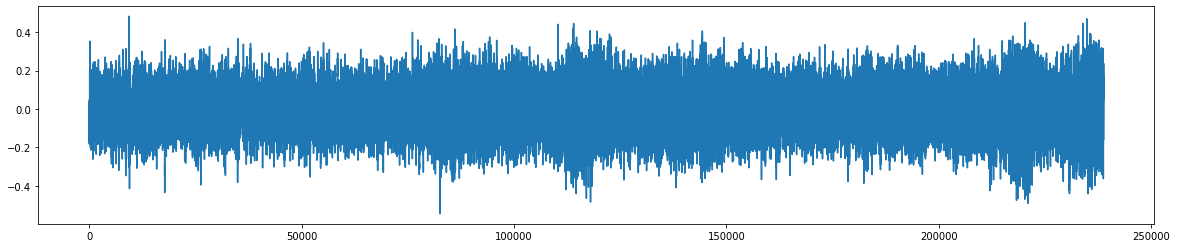

In [ ]:
# time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data)

In [ ]:
# Target voice play
IPython.display.Audio(data=data, rate=rate, autoplay=True)

In [ ]:
# Function for noise generation
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)

In [ ]:
# noise generation
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 10000, samples=len(data), samplerate=rate)*100
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise #noisy signal

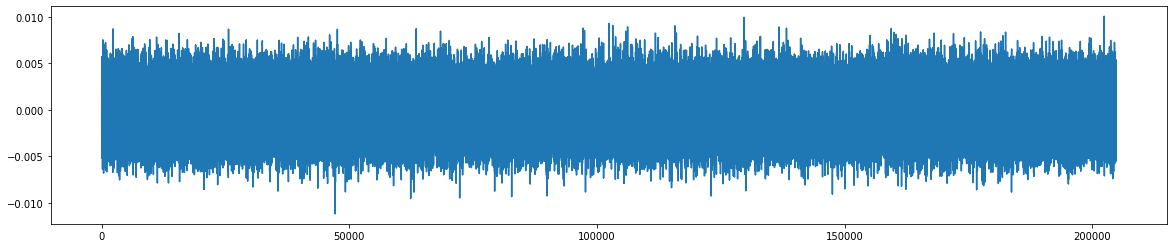

In [ ]:
a = np.ones(204800)
b = fftnoise(a)
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(b)
IPython.display.Audio(data=b,rate=rate,autoplay=True)

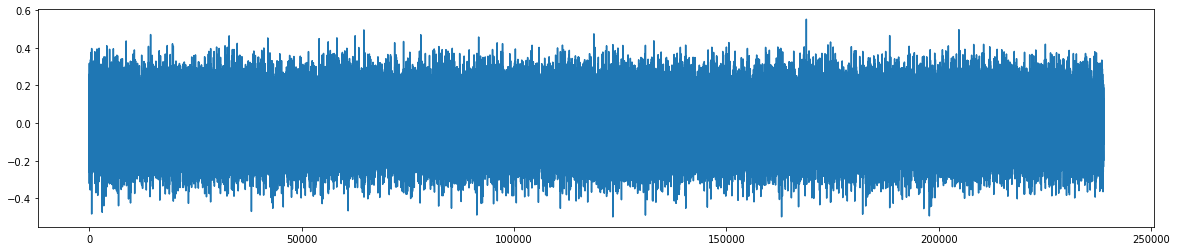

In [ ]:
# Noisy sound time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise)

In [ ]:
# Noisy sound play
IPython.display.Audio(data=noise, rate=rate, autoplay=True)

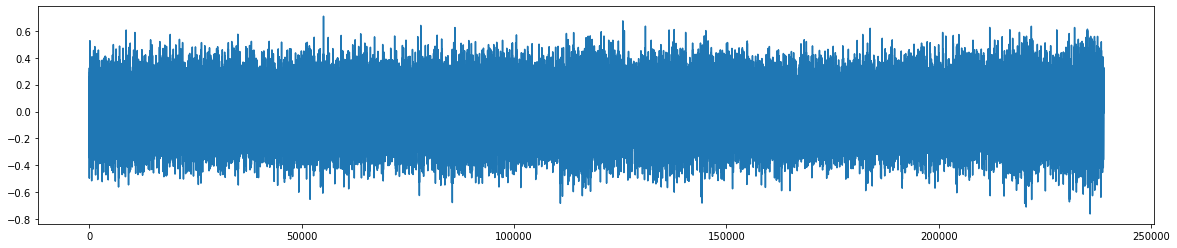

In [ ]:
# Noisy sound time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_band_limited)

In [ ]:
# Noisy sound play
IPython.display.Audio(data=audio_clip_band_limited, rate=rate, autoplay=True)

In [ ]:
# Active Noice Canceling
def ANC(original, noise_primary, noise_secondary, CHUNK = 100, mu = 0.1):

    # Filter for canceling signal
    Wz = np.zeros(CHUNK)

    # Noise sound we can hear
    output = np.zeros(len(original))

    # Entire sound we can hear
    output_origin = np.zeros(len(original))

    # Online adaptation
    for n in range(CHUNK, len(noise_primary)):

        # Only use a previous chunk sound 
        x_chunk = noise_primary[(n-CHUNK+1):(n+1)][::-1]
        xp_chunk = noise_secondary[(n-CHUNK+1):(n+1)][::-1]

        # Active noise canceling
        output[n] = noise_primary[n] - np.sum(Wz*x_chunk)
        output_origin[n] = original[n] - np.sum(Wz*x_chunk)

        # Update the filter for canceling signal
        Wz = Wz + mu*xp_chunk*output[n]

    return output, output_origin


In [ ]:
# ANC for the ideal case
canceled_noise, canceled_origin = ANC(audio_clip_band_limited, noise, noise, mu = 0.1)

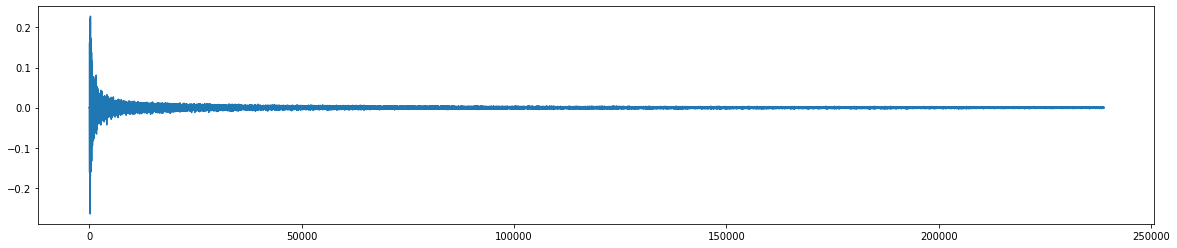

In [ ]:
# Noisy sound time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(canceled_noise)
# Noisy sound play
IPython.display.Audio(data=canceled_noise, rate=rate, autoplay=True)

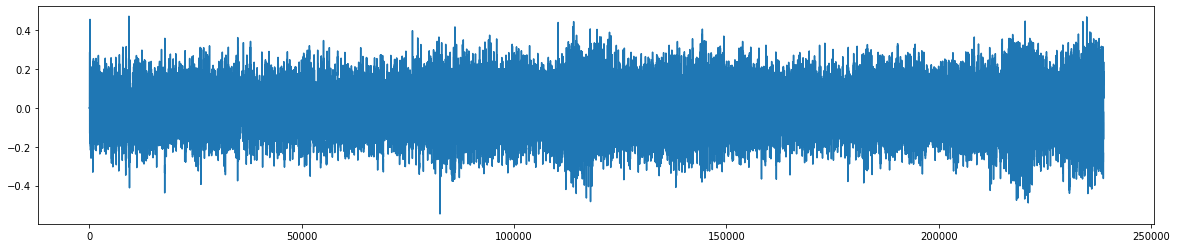

In [ ]:
# Noisy sound time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(canceled_origin)
# Noisy sound play
IPython.display.Audio(data=canceled_origin, rate=rate, autoplay=True)

In [ ]:
# Implement the difference between the primary noise and the secondary noise
Pz = np.ones(3)/3 * 0.3
noise_primary = noise * 0.8
noise_secondary = np.convolve(noise, Pz)

In [ ]:
# Ideal ANC with real hardware
canceled_noise_real, canceled_origin_real = ANC(audio_clip_band_limited, noise_primary, noise_secondary)

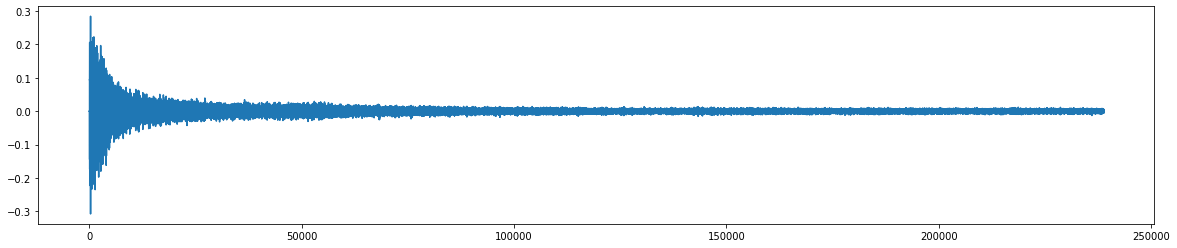

In [ ]:
# Noisy sound time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(canceled_noise_real)
# Noisy sound play
IPython.display.Audio(data=canceled_noise_real, rate=rate, autoplay=True)

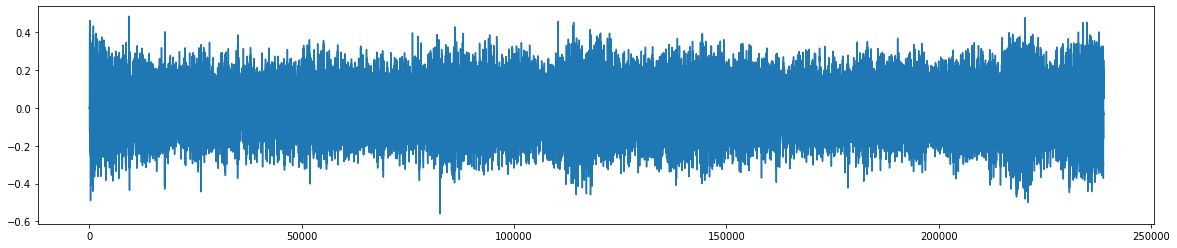

In [ ]:
# Noisy sound time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(canceled_origin_real)
# Noisy sound play
IPython.display.Audio(data=canceled_origin_real, rate=rate, autoplay=True)

In [ ]:
# Align the primary noise and the secondary noise (FILTER)
def secondary_deconv_filter(noise_primary, noise_secondary, CHUNK = 100, mu = 0.001):

    # Target filter
    Sz = np.zeros(CHUNK)

    # error values
    e = np.zeros(len(noise_primary))
    for n in range(CHUNK, len(noise_primary)):

        # Segment extraction for the primary noise
        x_chunk = noise_primary[(n-CHUNK+1):(n+1)][::-1]

        # Segment extraction for the second noise
        xp_chunk = noise_secondary[(n-CHUNK+1):(n+1)][::-1]

        e[n] = noise_primary[n] - np.sum(Sz*xp_chunk)

        Sz = Sz + mu*xp_chunk*e[n]

    return Sz

In [ ]:
# Alignment of the primary and secondary noises
Sz = secondary_deconv_filter(noise_primary, noise_secondary)
deconv_noise_secondary = np.convolve(noise_secondary, Sz)

# ANC with the aligned noises
canceled_noise_real_deconv, canceled_origin_real_deconv = ANC(audio_clip_band_limited, noise_primary, deconv_noise_secondary)

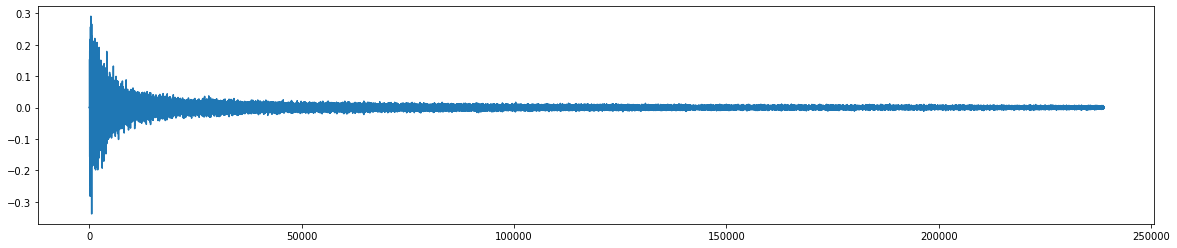

In [ ]:
# Noisy sound time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(canceled_noise_real_deconv)
# Noisy sound play
IPython.display.Audio(data=canceled_noise_real_deconv, rate=rate, autoplay=True)

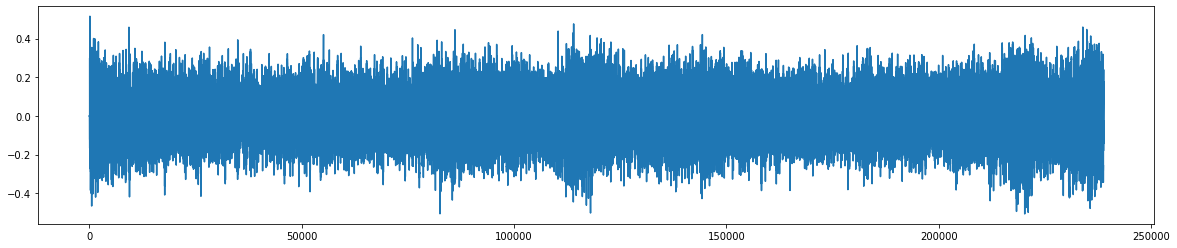

In [ ]:
# Noisy sound time-domain plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(canceled_origin_real_deconv)
# Noisy sound play
IPython.display.Audio(data=canceled_origin_real_deconv, rate=rate, autoplay=True)